In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import starrotate as sr
from starrotate import rotation_tools as rt

plotpar = {'axes.labelsize': 25,
           'font.size': 25,
           'legend.fontsize': 15,
           'xtick.labelsize': 22,
           'ytick.labelsize': 22,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [2]:
df = pd.read_csv("Table_1_Periodic.txt")

label_df = df.iloc[:1000]
label_df.to_csv("labels.csv")

df.head()

,kepid,Teff,logg,Mass,Prot,Prot_err,Rper,LPH,w,DC,Flag
0,892376,3813,4.47,0.4699,1.532,0.007,7306.69,0.823,0.4503,0,---
1,1026146,4261,4.57,0.6472,14.891,0.120,11742.56,1.405,0.7229,0,---
2,1026474,4122,4.56,0.5914,1.569,0.006,30471.80,1.204,0.6061,0,---
3,1162635,3760,4.77,0.4497,15.678,0.019,10207.47,0.978,0.5445,1,---
4,1164102,4045,4.62,0.5606,31.496,0.474,5139.74,0.568,0.3939,0,---


Calculate ACFs for all stars.

In [3]:
# from tqdm import trange
# from tools import load_lcs_and_compute_acfs

# N = 1000
# Npixel = 500
# _acfs, _lags = load_lcs_and_compute_acfs(df.kepid.values[:N], Npixel)

In [4]:
# y, x = _acfs*1, _lags*1
# acfs, lags = _acfs*1, _lags*1

Save ACFs to pickle file.

In [5]:
# import pickle

# output = open('acfs.pkl', 'wb')
# pickle.dump(_acfs, output)
# output.close()

Check file

(1000, 500)


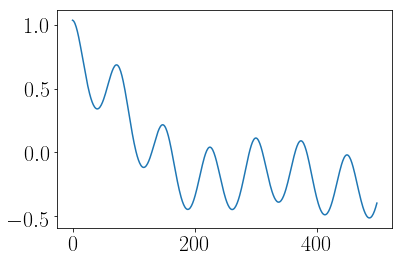

In [6]:
_acfs = np.load("acfs.pkl")
print(np.shape(_acfs))
plt.plot(_acfs[0, :])

Convert to Python 2.7

In [7]:
# #!/usr/bin/env python3

# with open("acfs.pkl", "rb") as f:
#     w = pickle.load(f)

# pickle.dump(w, open("acfs_py2.pkl","wb"), protocol=2)

Trim ACF down to just the starting few pixels.

In [24]:
N = 50 # Number of stars (max = 1000, currently)

print(np.shape(_acfs))
npixels = 10
acfs = _acfs[:N, :npixels]
print(np.shape(acfs))

(1000, 500)
(50, 10)


Simulate data

In [51]:
P, T = df.Prot.values[:N], df.Teff.values[:N]

w0 = np.linspace(0, 100, npixels) #[1, .5, .5, .8, .1, .3, .7]
w1 = np.linspace(100, 0, npixels)
w2 = np.linspace(0, .1, npixels)
for i in range(N):
    acfs[i, :] = w0 + w1*P[i] + w2*T[i]# + w[3]*P[i]**2 + w[4]*T[i]**2 + w[5]*P[i]*T[i]

1.5319999999999998 3813


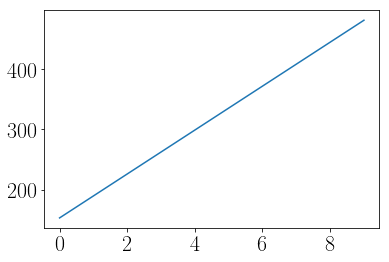

In [53]:
plt.plot(acfs[0, :])
print(P[0], T[0])

In [54]:
from lcc import LCC

# The labels
labels = np.array([P, T]).T#, P**2, T**2, P*T]).T

# Set up the Cannon.
lcc = LCC(labels, acfs)

# train
weights = lcc.train()

# predict
predicted, chi2, success = lcc.predict(acfs)

100%|██████████| 50/50 [00:00<00:00, 799.48it/s]


In [55]:
np.shape(weights)
m = (.9 < weights[:, 0]) * (weights[:, 0] < 1.1)
sum(m)

0

[1. 1.]
1.5319999999999998 3813 [1.53199999e+00 3.81300000e+03]


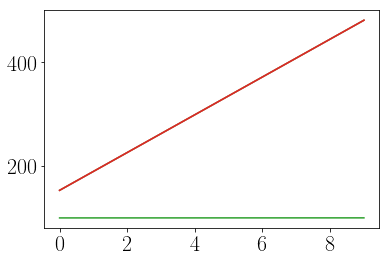

In [56]:
i = 0
plt.plot(acfs[i, :])
plt.plot(lcc.model(labels[i, :]))
inits = np.ones(np.shape(labels)[1])
print(inits)
plt.plot(lcc.model([1, 1]))
plt.plot(lcc.model(predicted[i, :]))
print(P[i], T[i], predicted[i, :])

In [57]:
print(np.shape(predicted))
print(predicted[0, :])
print(labels[0, :])

(50, 2)
[1.53199999e+00 3.81300000e+03]
[1.532e+00 3.813e+03]


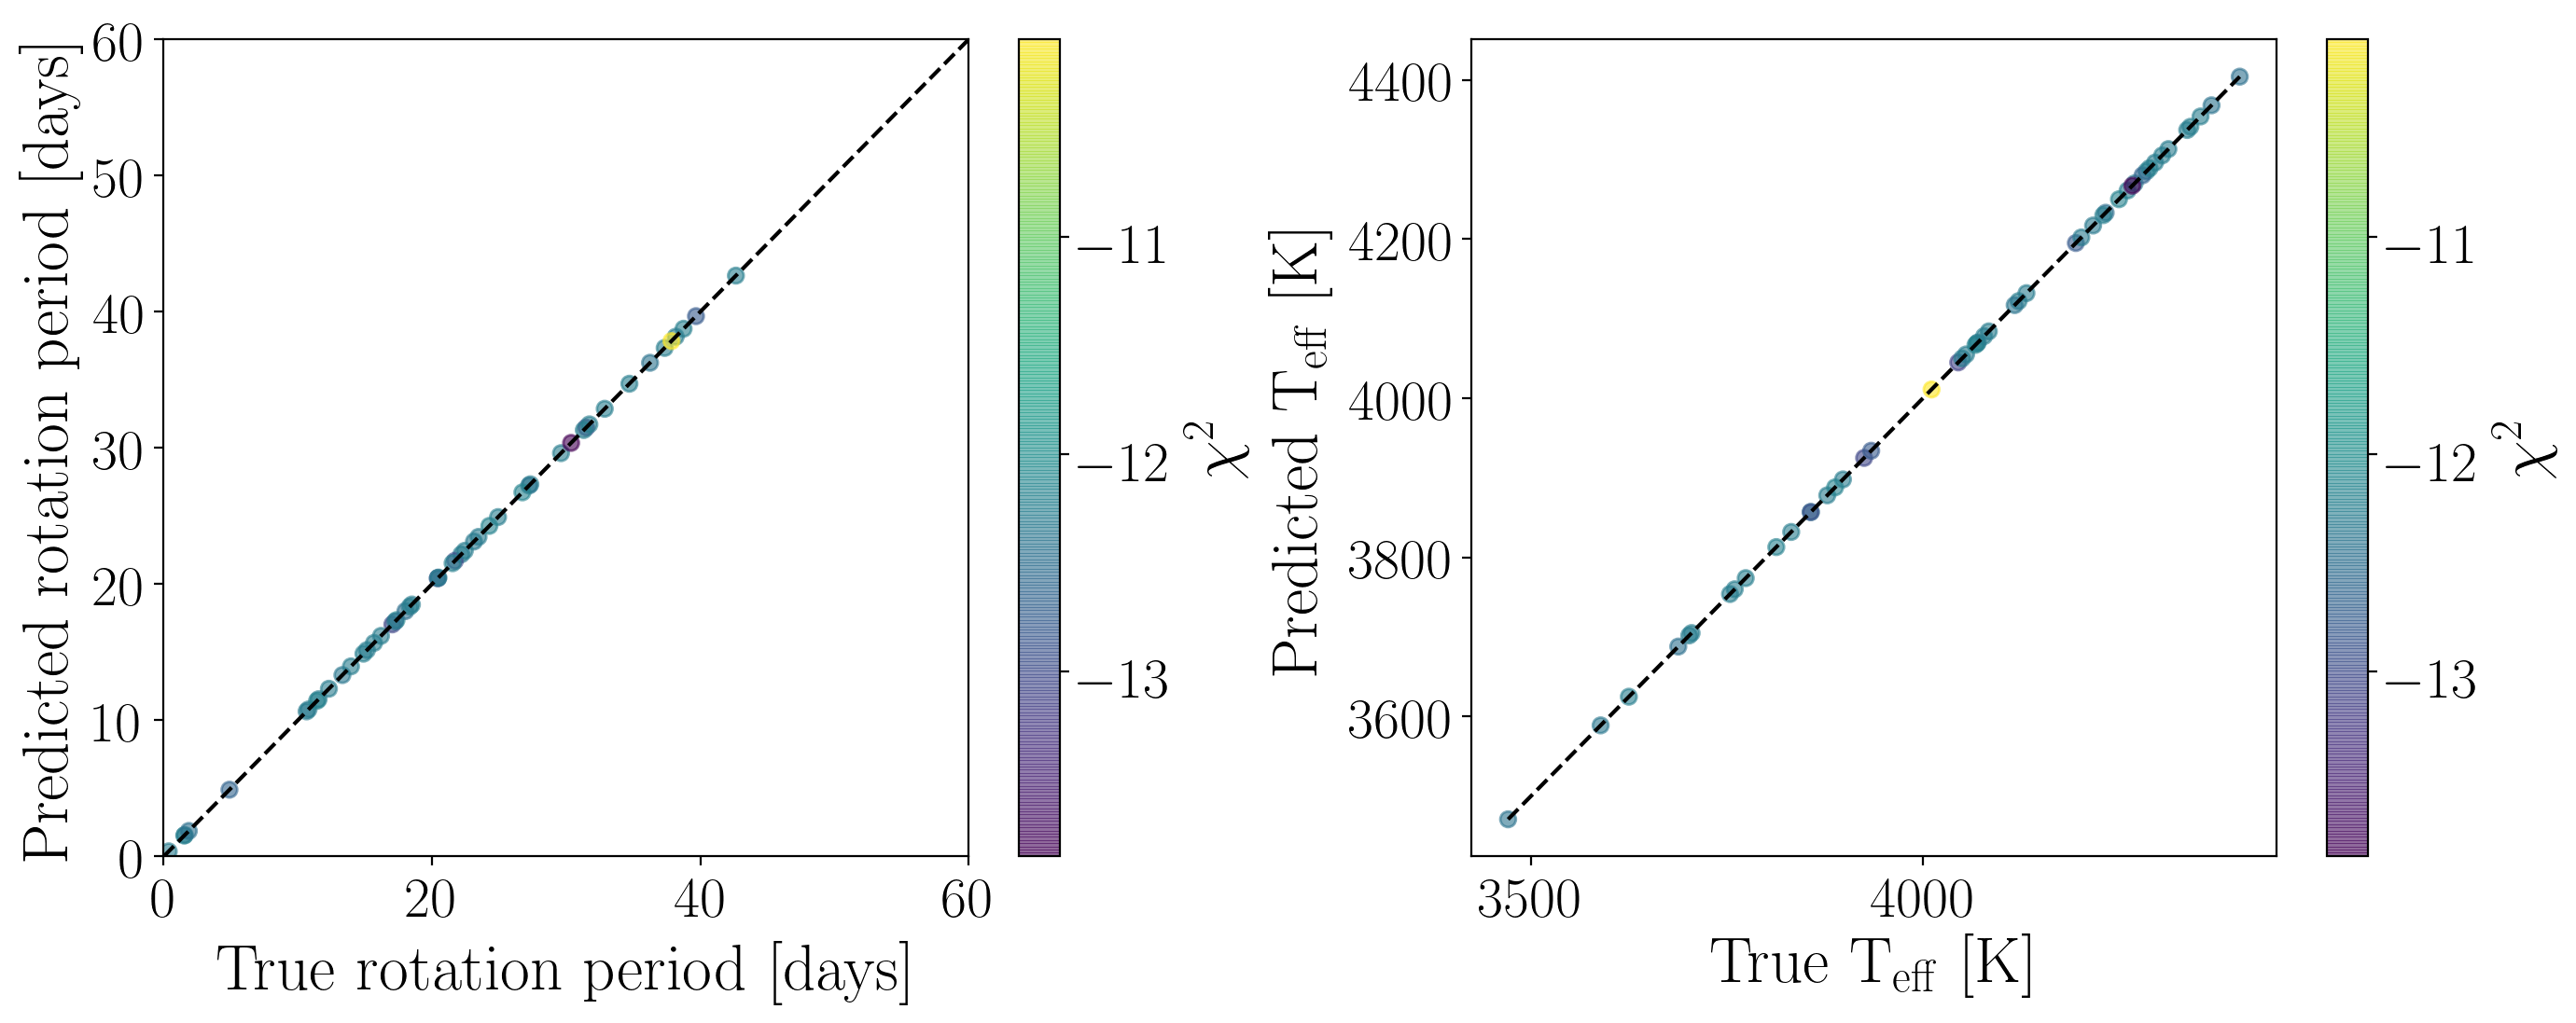

In [58]:
plt.figure(figsize=(16, 6), dpi=200)

plt.subplot(1, 2, 1)
plt.scatter(P, predicted[:, 0], c=np.log10(chi2), alpha=.6, rasterized=True)
plt.xlabel("$\mathrm{True~rotation~period~[days]}$")
plt.ylabel("$\mathrm{Predicted~rotation~period~[days]}$");
xs = np.linspace(0, 65, 100)
plt.plot(xs, xs, color="k", ls="--")
plt.xlim(0, 60)
plt.ylim(0, 60)
plt.colorbar(label="$\mathrm{\chi^2}$")

plt.subplot(1, 2, 2)
plt.scatter(T, predicted[:, 1], c=np.log10(chi2), alpha=.6, rasterized=True)
plt.xlabel("$\mathrm{True~T_{eff}~[K]}$")
plt.ylabel("$\mathrm{Predicted~T_{eff}~[K]}$");
xs = np.linspace(min(T), max(T), 100)
plt.plot(xs, xs, color="k", ls="--")
# plt.xlim(min(xs), max(xs))
# plt.ylim(min(xs), max(xs))
plt.colorbar(label="$\mathrm{\chi^2}$")

plt.subplots_adjust(bottom=.15, wspace=.3)